In [ ]:
0-0

In [ ]:
# install.packages('gplots', repos='http://cran.us.r-project.org')
# source("https://bioconductor.org/biocLite.R")
# biocLite("vsn")
# install.packages('RColorBrewer', repos='http://cran.us.r-project.org')
# source("https://bioconductor.org/biocLite.R")
# biocLite("edgeR")

library(tidyr)
library(dplyr)
library(ggplot2)
# library(missForest)
# library(huge)
# library(JGL)
library(msgl)
library(glmnet)
library(gplots)
library(RColorBrewer)
library(edgeR)

In [2]:
# setwd("/proj/price1/CHDI/studies/allelic_series/HDinHD_FPKMs/")

In [3]:
# # code to generate the dataframes, in case we wan to do it again
# # say for raw counts

# # empty data frame to put all data in
# df <- data.frame()

# # loop though all dirs and append data to df
# dirs_to_check <- list.files(pattern="*mrnacounts")
# for (somedir in dirs_to_check) {
    
#     # get timepoint and tuissue from dir name
#     namevec <- strsplit(somedir,'_')
#     timepoint <- as.numeric(strsplit(namevec[[1]][1],"m")[[1]])
#     tissue <- namevec[[1]][2]

#     # find the FPKM xls file and read in data
#     myfile <- list.files(path=somedir, pattern="*rawcounts.xls")

#     data <- read.table(file.path(somedir,myfile), header=TRUE, sep="\t")
    
#     # get genes as cols, mice as rows
#     transposed_data <- t(data[-c(1:3)])
#     colnames(transposed_data) <- data[,1]

#     # add in columns for timepoint and tisssue
#     nsamples <- dim(transposed_data)[[1]]
#     info_df <- data.frame(Tissue=rep(tissue,nsamples),Timepoint=rep(timepoint,nsamples))
#     transposed_data <- cbind(info_df,transposed_data)
    
#     # append to main df
#     df <- rbind(df,transposed_data)
# }

# df[,'Timepoint'] <- as.factor(df[,'Timepoint'])

# decoder_df <- read.table("master_decoder_ring.csv", header=TRUE, sep=",")
# decoder_df_mrna <- decoder_df[decoder_df$Seq.Type == "mRNA",]
# rownames(decoder_df_mrna) <- decoder_df_mrna$observationid
# df_annotated <- cbind(decoder_df_mrna[c("Numeric.Q","Sex","Genotyped.CAG")],df)

# all_mrna_data_raw <- df_annotated
# save(all_mrna_data_raw,file="all_mrna_data_RAW.Rdata")


# all_mrna_data_npn <- cbind(data.frame(ObservationID=rownames(all_mrna_data_npn)),all_mrna_data_npn)

# all_mrna_data_npn_tidy <- gather(all_mrna_data_npn, Gene, Expression,
#                              -Numeric.Q,
#                              -Sex,
#                              -Genotyped.CAG,
#                              -Tissue,
#                              -Timepoint,
#                              -ObservationID
#                             )
    
# save(all_mrna_data_npn,file="all_mrna_data_tidy_NPN.Rdata")

In [7]:
load("all_mrna_data_NPN.Rdata")
load("all_mrna_data_tidy_NPN.Rdata")
load("all_mrna_data_FPKM.Rdata")
load("all_mrna_data_tidy_FPKM.Rdata")
load("all_mrna_data_RAW.Rdata")
load("all_mrna_data_tidy_RAW.Rdata")

In [5]:
ls()

[1] "all_mrna_data_npn"      "all_mrna_data_npn_tidy"

In [6]:
sum(is.na(all_mrna_data_npn))

[1] 40

In [10]:
# unique(c(dim(all_mrna_data_FPKM),dim(all_mrna_data_npn),dim(all_mrna_data_raw)))

In [11]:
head(all_mrna_data_npn_tidy)

,ObservationID,Numeric.Q,Sex,Genotyped.CAG,Tissue,Timepoint,Gene,Expression
1,X28210_1_641L_striatum_Q20_WT_M_L3.LB9,20,MALE,7,cortex,10,0610005C13Rik,-1.33965005372848
2,X299971_Q80B0021_10_L4.D709,80,FEMALE,85.137,cortex,10,0610005C13Rik,0.223967597372717
3,X299972_Q80B0021_06_L4.D710,80,FEMALE,84.098,cortex,10,0610005C13Rik,-0.426704096771064
4,X299973_Q111B0021_06_L4.D711,111,FEMALE,127.973,cortex,10,0610005C13Rik,0.16111741792323
5,X299974_Q20B0017_04_L4.D712,20,MALE,20.0086,cortex,10,0610005C13Rik,0.0176310948025585
6,X299975_Q175B0591_08_L28,175,MALE,198.141,cortex,10,0610005C13Rik,-0.754073718017269


In [12]:
unique(all_mrna_data_npn_tidy$Numeric.Q)

[1]  20  80 111 175  92 140

In [276]:
data_subset_cortex <- filter(all_mrna_data_raw, 
                    Tissue == "cortex",
                    Timepoint == 10
                    )
dim(data_subset_cortex)

[1]    56 12896

In [297]:
X <- data_subset_cortex[,-c(1:5)]
y <- data_subset_cortex[1]
dim(X)
dim(y)
X[is.na(X)] <- 0

y[y == 20] <- 0
y[y > 20] <- 1

[1]    56 12891

[1] 56  1

In [298]:
split_data <- function(data_mat,outcomes,p=0.75) {
    if (nrow(data_mat) != nrow(outcomes)){ 
        stop("number of rows in feature matrix doesn't match length of outcomes")
    }
    n <- nrow(outcomes)
    s <- floor(p*n)
    sample_inds <- sample(seq_len(n), size = s)
    return(sample_inds)
}

In [299]:
traintest_inds <- split_data(X,y,p=0.75)
X_traintest <- as.matrix(X[c(traintest_inds),])
y_traintest <- as.factor(y[c(traintest_inds),])
X_holdout <- as.matrix(X[-c(traintest_inds),])
y_holdout <- as.factor(y[-c(traintest_inds),])

head(X_traintest[,1:10])

,0610005C13Rik,0610007N19Rik,0610007P14Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik
5,0.01763109,-1.40179375,-0.90758188,-0.33206124,-0.71953997,-0.92892897,-0.13260754,-0.29505317,-0.71499942,1.04262935
29,0.28219615,-1.14415378,-0.46951653,-0.33206124,0.31165469,0.17184067,0.93704212,0.01763109,0.20593221,1.04262935
49,0.2821962,0.8737334,0.2293919,-0.3320612,0.3116547,0.9208755,1.4697684,0.2366348,0.5910293,0.2185497
48,0.08826351,-0.67476318,-0.12549748,-0.33206124,0.92892897,-0.65069680,0.68139339,-0.08295536,0.13616502,0.21854972
26,-0.4267041,-1.3227999,-1.0951819,-0.3320612,-0.7195400,-1.2436033,-0.0458543,-0.3488588,-0.1987368,1.0426293
3,-0.42670410,-0.54965361,-0.54149051,-0.33206124,-0.71953997,-0.45971468,0.37329541,-0.18079153,-0.01057831,-0.23663477


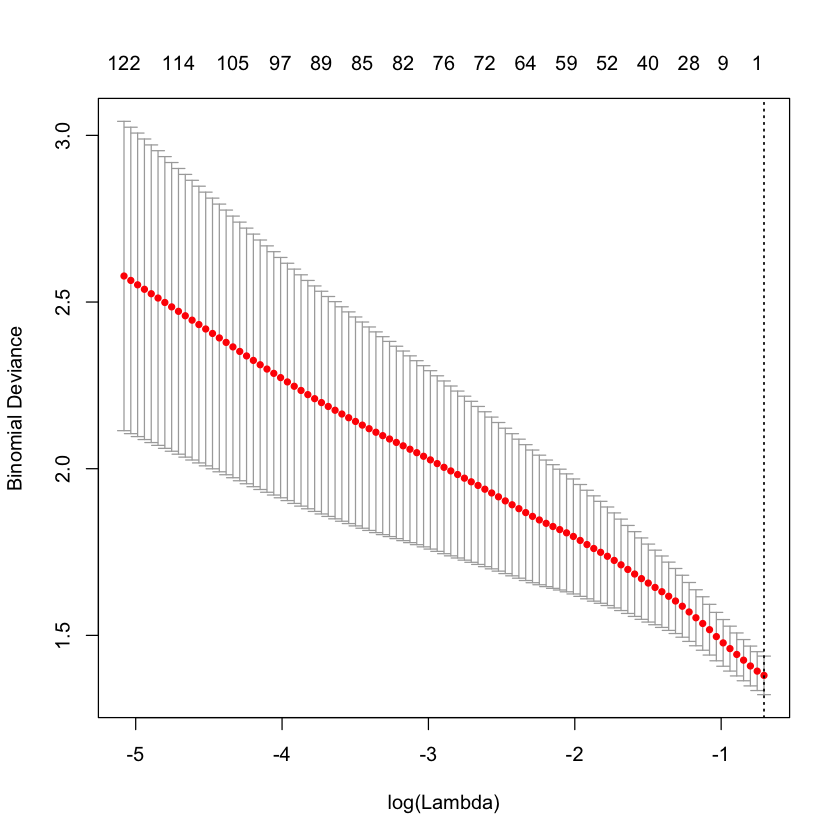

In [300]:
cv.glmmod <- cv.glmnet(X_traintest,y=y_traintest,alpha=0.5,family='binomial')
plot(cv.glmmod)

In [303]:
glmmod <- glmnet(X_traintest,y_traintest,alpha=0.25,family='binomial')

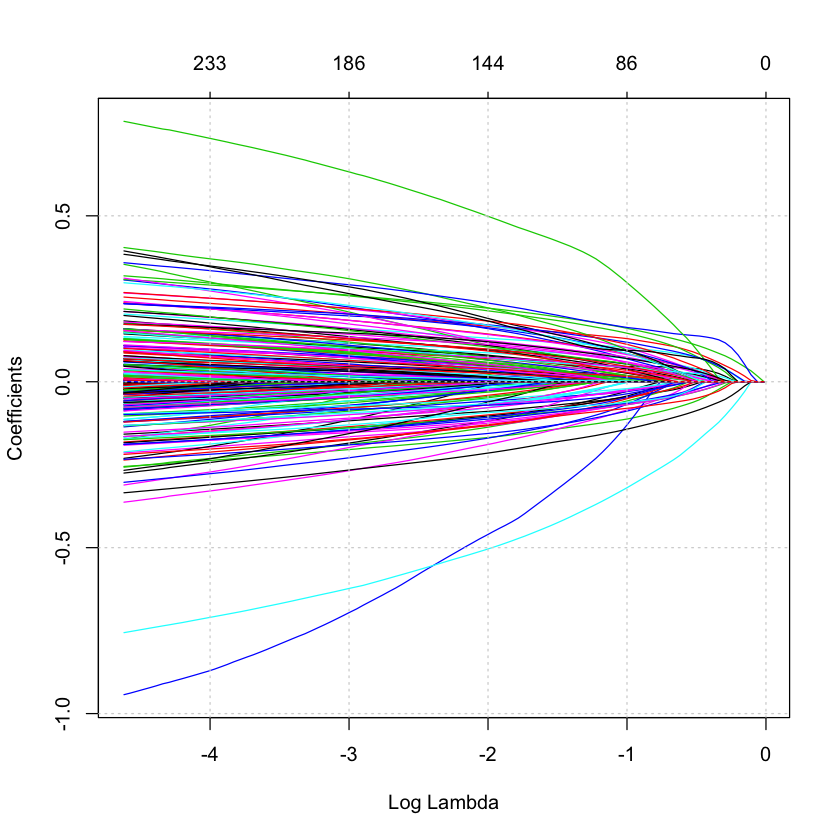

In [304]:
plot(glmmod,xvar="lambda")
grid()

In [305]:
pred = predict(glmmod, newx=X_holdout, type="class")
colMeans(y_holdout == pred)

s0        s1        s2        s3        s4        s5        s6        s7 
0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 
       s8        s9       s10       s11       s12       s13       s14       s15 
0.5714286 0.5714286 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 
      s16       s17       s18       s19       s20       s21       s22       s23 
0.5000000 0.5000000 0.5000000 0.5000000 0.5714286 0.5714286 0.5714286 0.5714286 
      s24       s25       s26       s27       s28       s29       s30       s31 
0.6428571 0.6428571 0.6428571 0.6428571 0.6428571 0.6428571 0.6428571 0.6428571 
      s32       s33       s34       s35       s36       s37       s38       s39 
0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5000000 
      s40       s41       s42       s43       s44       s45       s46       s47 
0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 
      s48       s49       s50       s51       s52       s53       s54       s55 
0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 
      s56       s57       s58       s59       s60       s61       s62       s63 
0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 
      s64       s65       s66       s67       s68       s69       s70       s71 
0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5714286 
      s72       s73       s74       s75       s76       s77       s78       s79 
0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 
      s80       s81       s82       s83       s84       s85       s86       s87 
0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 
      s88       s89       s90       s91       s92       s93       s94       s95 
0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 0.5714286 
      s96       s97       s98       s99 
0.5714286 0.5714286 0.5714286 0.5714286

In [306]:
L <- 35
degs <- names(glmmod$beta[,L][glmmod$beta[,L] != 0])
str(degs)

 chr [1:117] "0610040J01Rik" "1700011L22Rik" "1700012I11Rik" ...


In [307]:
data_subset_tidy <- filter(all_mrna_data_npn_tidy, 
                    Tissue == "cortex",
                    Timepoint == 10,
                    Gene %in% degs
                    )
head(data_subset_tidy)

,ObservationID,Numeric.Q,Sex,Genotyped.CAG,Tissue,Timepoint,Gene,Expression
1,X28210_1_641L_striatum_Q20_WT_M_L3.LB9,20,MALE,7,cortex,10,0610040J01Rik,-0.818585167802134
2,X299971_Q80B0021_10_L4.D709,80,FEMALE,85.137,cortex,10,0610040J01Rik,-0.0723457971323147
3,X299972_Q80B0021_06_L4.D710,80,FEMALE,84.098,cortex,10,0610040J01Rik,-0.559908434506091
4,X299973_Q111B0021_06_L4.D711,111,FEMALE,127.973,cortex,10,0610040J01Rik,-0.661589340779779
5,X299974_Q20B0017_04_L4.D712,20,MALE,20.0086,cortex,10,0610040J01Rik,-0.818585167802134
6,X299975_Q175B0591_08_L28,175,MALE,198.141,cortex,10,0610040J01Rik,-0.0493842766973234


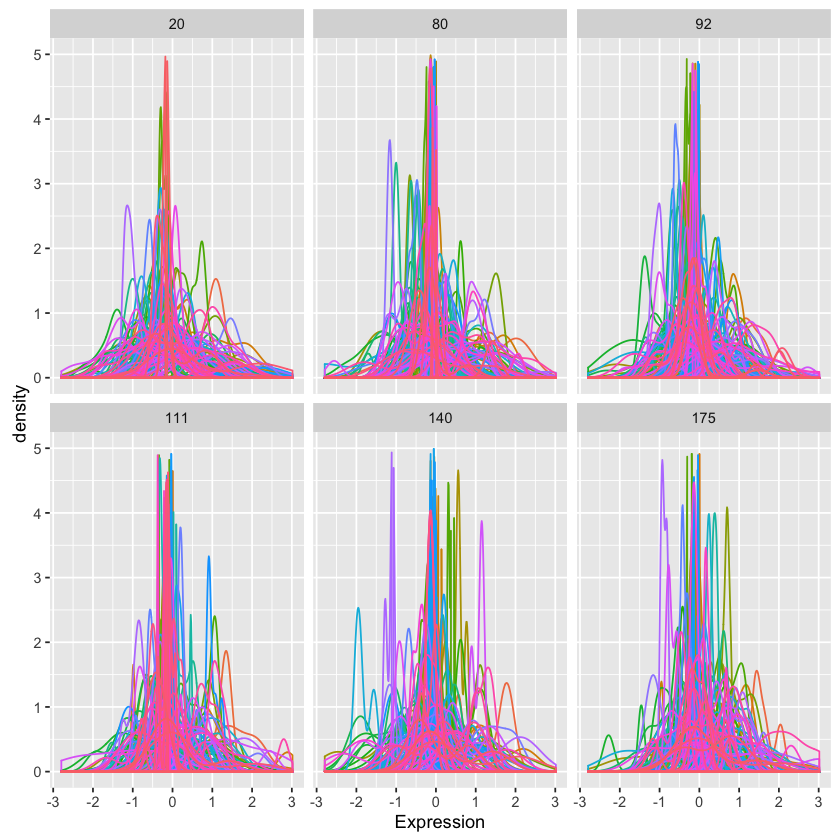

In [308]:
d <- ggplot(data_subset_tidy,aes(Expression,colour = Gene)) + 
    geom_density() +
    facet_wrap(~ Numeric.Q) +
    ylim(0,5) +
    theme(legend.position = "None")

d

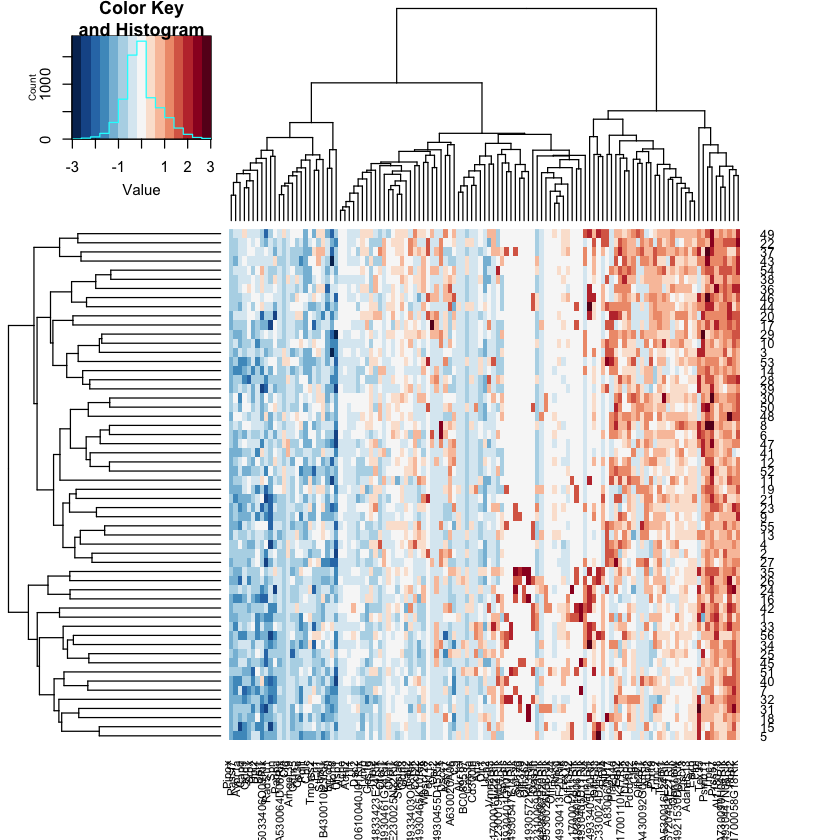

In [309]:
mypal <- rev(brewer.pal(n=11,name = 'RdBu'))

heatmap.2(as.matrix(X[,degs]), trace='none', col=colorRampPalette(mypal))

In [ ]:
mypal <- rev(brewer.pal(n=11,name = 'RdBu'))
heatmap.2(as.matrix(all_mrna_data_FPKM[-c(1:5)]), trace='none', col=colorRampPalette(mypal))

In [6]:
data_subset_tidy <- filter(all_mrna_data_npn_tidy, 
                    Tissue == "cortex",
                    Timepoint == 10,
                    Gene %in% degs
                    )

ERROR: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)): object 'all_mrna_data_npn_tidy' not found


In [ ]:
tally(group_by(all_mrna_data_raw_tidy, Tissue, TImepoint))